# Understand the number of MILP calls

In [12]:
import sys
sys.path.append('../../')

from os import listdir
from time import time
import numpy as np
from matplotlib import pyplot as plt


import pickle as pkl



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Customize sequential_HybridSIPP to count the MILP calls
from panav.HybridSIPP import HybridSIPP
def sequential_HybridSIPP(HG,return_graph = False,Delta = 2.0, Kmax = 3,return_on_failure=True):
    
    agents = np.arange(len(HG.start_nodes))
    graph_plans = []
    continuous_plans = []

    U = {e:[] for e in HG.edges} # Edge traversal times
    C = {s:[] for s in HG} # Node visit times

    MILP_calls = 0
    straight_calls = 0

    def update_traversal_records(U,C,gp):
        
        for s,t in gp:
            C[s].append(t)
        
        k = len(gp)
        for i in range(k-1):
            s,t = gp[i]
            sp,tp  = gp[i+1]
            U[s,sp].append((t,tp))
        return U,C
            

    for a in agents:
        print(a)
        t0 = time()

        result = None
        for Km in range(Kmax+1):
            print('Km=',Km)

            data_record_dict = {}

            result = HybridSIPP(HG,U,C,HG.start_nodes[a],HG.goal_nodes[a],continuous_plans,Delta,
                                Kmax=Km,
                                data_record_dict=data_record_dict)
            if result is not None:
                break
            
        if result is not None:
            gp,cp = result
        else:
            print("Solver failed.")
            if return_on_failure:
                break
            else:
                return None
        
        print('Solve time',time()-t0)
        
        U,C = update_traversal_records(U,C,gp)
        graph_plans.append(gp)
        continuous_plans.append(cp)

        MILP_calls += data_record_dict['MILP_calls']
        straight_calls +=  data_record_dict['straight_calls']

    return MILP_calls,straight_calls

In [14]:
def get_env_name(filename):
    fs = filename.split('.')
    return fs[0]


# Load environment presets
env_names = [get_env_name(fn) for fn in listdir('./envs')]

env_infos = {}

for name in env_names:
    with open(f'./envs/{name}.pkl','rb') as fp:
        env_infos[name] = pkl.load(fp)

In [15]:

bloating_r = 0.5
vmax = 1.0

TIMEOUT = 200


In [21]:
save_file = './data/NumCallAnalysis.pkl' 


MILP_calls = {}
straight_calls ={}

N_range = np.arange(2,21,2)

for env_name in env_names:
    env_info = env_infos[env_name]
    MILP_calls[env_name] = []
    straight_calls[env_name] = []
    for N in N_range: 
        # Construct the environment
        constructor = env_info['constructor']
        specs = env_info['specs']

        print('Building the environment...')
        HG = constructor(**specs,N_agent = N)

        mc, sc = sequential_HybridSIPP(HG,Kmax = 5,Delta=3.0,return_on_failure=False)

        MILP_calls[env_name].append(mc)
        straight_calls[env_name].append(sc)

        with open(save_file,'wb') as fp:
            pkl.dump(dict(MILP_calls=MILP_calls,straight_calls=straight_calls),fp)

Building the environment...
0
Km= 0
Solve time 0.004394054412841797
1
Km= 0
Solve time 0.002584218978881836


/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/tianpengzhang/opt/miniconda3/envs/PA-NAV/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


KeyError: 'MultiTunnel'

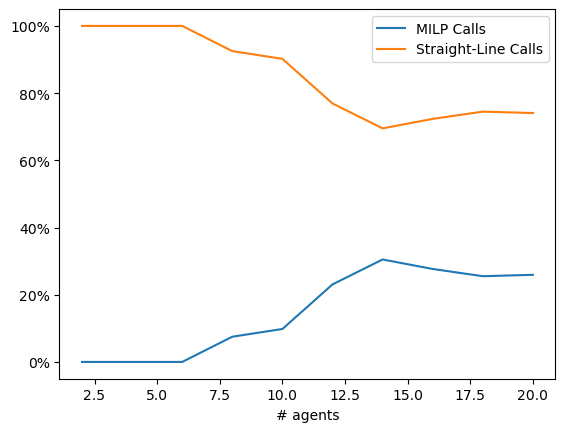

In [20]:
from matplotlib.ticker import PercentFormatter

for name in MILP_calls:
    mcs = np.array(MILP_calls[name])
    scs = np.array(straight_calls[name])
    cs = mcs+scs
    plt.plot(N_range,mcs/cs * 100,label='MILP Calls')
    plt.plot(N_range,scs/cs * 100,label='Straight-Line Calls')
    plt.xlabel("# agents")
    plt.legend()

    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.show()